In [1]:
import numpy as np
import pandas as pd
import seaborn as sns # libreria utile per matrice di confusione
# import plotly.express as px
from collections import Counter
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, make_scorer, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import shap
import pickle
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay
import sys

In [2]:
plt.rcParams["mathtext.fontset"]
plt.rcParams.update({'font.size': 28, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

In [3]:
transaction_frequency_opcode = ['address', 'balance', 'lifetime', 'tx_in', 'tx_out', 'investment_in',
 'payment_out', 'investment_to_contract/tx_in', 'payment_from_contract/tx_out',
 '#addresses_paying_contract', '#addresses_paid_by_contract', 'mean_v1', 'sdev_v1', 'mean_v2', 'sdev_v2', 'paid_rate',
 'paid_one', 'percentage_some_tx_in', 'sdev_tx_in', 'percentage_some_tx_out', 'sdev_tx_out', 'owner_gets_eth_Wo_investing',
 'owner_gets_eth_investing', 'owner_no_eth', 'PUSH', 'DUP', 'JUMPDEST', 'STOP', 'MSTORE', 'JUMPI', 'REVERT', 'CALLVALUE',
 'ISZERO', 'CODECOPY', 'RETURN', 'LOG', 'SHA3', 'MSTORE8', 'SWAP', 'POP', 'ADD', 'MLOAD', 'AND', 'SUB', 'CALLDATALOAD', 'EXP',
 'MUL', 'SLOAD', 'EQ', 'JUMP', 'DIV', 'CALLER', 'CALLDATACOPY', 'SSTORE', 'NOT', 'CALL', 'LT', 'GT', 'OR', 'ADDRESS', 'TIMESTAMP',
 'GASLIMIT', 'GAS', 'ORIGIN', 'BALANCE', 'CALLDATASIZE', 'SAR', 'MSIZE', 'CODESIZE', 'COINBASE', 'CREATE2', 'EXTCODESIZE', 'CALLCODE', 'SHL',
 'BLOCKHASH', 'RETURNDATASIZE', 'SHR', 'GETPC', 'DELEGATECALL', 'MOD', 'ADDMOD', 'NUMBER', 'XOR', 'SLT', 'EXTCODECOPY', 'MULMOD', 'CREATE', 'SELFDESTRUCT',
 'STATICCALL', 'RETURNDATACOPY', 'SGT', 'DIFFICULTY', 'SMOD', 'BYTE', 'SIGNEXTEND', 'CHAINID', 'SELFBALANCE', 'GASPRICE', 'EXTCODEHASH', 'SDIV', 'target']

In [4]:
best_features_set = ['tx_in',
 'investment_to_contract/tx_in',
 'mean_v1',
 'sdev_v1',
 'paid_one',
 'PUSH',
 'DUP',
 'JUMPDEST',
 'STOP',
 'MSTORE',
 'JUMPI',
 'REVERT',
 'CALLVALUE',
 'CODECOPY',
 'RETURN',
 'LOG',
 'SHA3',
 'MSTORE8',
 'SWAP',
 'POP',
 'ADD',
 'MLOAD',
 'AND',
 'SUB',
 'CALLDATALOAD',
 'EXP',
 'MUL',
 'SLOAD',
 'EQ',
 'DIV',
 'CALLER',
 'CALLDATACOPY',
 'SSTORE',
 'NOT',
 'CALL',
 'LT',
 'ADDRESS',
 'GASLIMIT',
 'GAS',
 'ORIGIN',
 'BALANCE',
 'MULMOD',
 'SGT']

In [5]:
ds_full_path= (r"C:\Users\lucap\OneDrive\Desktop\Scam on blockchain\Smart Ponzi\DS_deployed_bytecode.csv")
db = pd.read_csv(ds_full_path, header = 0, delimiter = ',')
db = db.fillna(0)
db

,address,balance,lifetime,tx_in,tx_out,investment_in,payment_out,investment_to_contract/tx_in,payment_from_contract/tx_out,#addresses_paying_contract,...,SIGNEXTEND,SHR,GASPRICE,EXTCODEHASH,SDIV,CHAINID,GETPC,SELFBALANCE,CODESIZE,target
0,0x0006157838d5a6b33ab66588a6a693a57c869999,0.000691,117,2,0,1,0,0.5000,0.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0x001a589dda0d6be37632925eaf1256986b2c6ad0,29.408568,318,11346,4,9685,4,0.8536,1.0,39,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0x00674045bb7c17f0aa1cde34780d6c51af548728,151.824186,1366,29,12,2,12,0.0690,1.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0x006bea43baa3f7a6f765f14f10a1a1b08334ef45,0.000000,21,9708,0,0,0,0.0000,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0x00a9f7d093c46d95f0318e4a6ffc6ed68f73044c,0.000000,0,78,1,76,1,0.9744,1.0,65,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7441,0xfd784da5c740c617aafb80399fa81b86e1da99a5,0.000000,461,9964,0,0,0,0.0000,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7442,0xfd7e33bc01a7493b189ddfdcc047500463be573a,0.000000,1,3,0,0,0,0.0000,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7443,0xfd82ffc0d08dcfd902cbf6e48550033b01f919cc,0.000000,48,8,2,2,2,0.2500,1.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7444,0xfd9683e9f2c62e08b6bf68123e18e527efa8fbbc,0.000000,1483,6,2,2,2,0.3333,1.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df_transaction_weighted_opcode = db[transaction_frequency_opcode].copy()

y = df_transaction_weighted_opcode.loc[:, ['target']].values
y = pd.DataFrame(y,columns=['target'])

dataset_account = db.iloc[:, 0:24]
dataset_opcode = db.iloc[:, 24:100]

dataset_opcode['all_opcode'] = dataset_opcode[list(dataset_opcode.columns)].sum(axis=1) #generate all_opcode
dataset_opcode = dataset_opcode[:].div(dataset_opcode['all_opcode'], axis=0)
dataset_opcode = dataset_opcode.drop(['all_opcode'], axis = 1)

df_transaction_weighted_opcode = pd.concat([dataset_account, dataset_opcode, y], axis=1)
df_transaction_weighted_opcode = df_transaction_weighted_opcode.fillna(0)

df_transaction_weighted_opcode

,address,balance,lifetime,tx_in,tx_out,investment_in,payment_out,investment_to_contract/tx_in,payment_from_contract/tx_out,#addresses_paying_contract,...,SIGNEXTEND,SHR,GASPRICE,EXTCODEHASH,SDIV,CHAINID,GETPC,SELFBALANCE,CODESIZE,target
0,0x0006157838d5a6b33ab66588a6a693a57c869999,0.000691,117,2,0,1,0,0.5000,0.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0x001a589dda0d6be37632925eaf1256986b2c6ad0,29.408568,318,11346,4,9685,4,0.8536,1.0,39,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0x00674045bb7c17f0aa1cde34780d6c51af548728,151.824186,1366,29,12,2,12,0.0690,1.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0x006bea43baa3f7a6f765f14f10a1a1b08334ef45,0.000000,21,9708,0,0,0,0.0000,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0x00a9f7d093c46d95f0318e4a6ffc6ed68f73044c,0.000000,0,78,1,76,1,0.9744,1.0,65,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7441,0xfd784da5c740c617aafb80399fa81b86e1da99a5,0.000000,461,9964,0,0,0,0.0000,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7442,0xfd7e33bc01a7493b189ddfdcc047500463be573a,0.000000,1,3,0,0,0,0.0000,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7443,0xfd82ffc0d08dcfd902cbf6e48550033b01f919cc,0.000000,48,8,2,2,2,0.2500,1.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7444,0xfd9683e9f2c62e08b6bf68123e18e527efa8fbbc,0.000000,1483,6,2,2,2,0.3333,1.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
col_name = transaction_frequency_opcode[1:-1]

In [9]:
addr= df_transaction_weighted_opcode.iloc[:, 0]
X = df_transaction_weighted_opcode.iloc[:, 1:-1].values # rimuovo la prima colonna che contiene gli indirizzi
y = df_transaction_weighted_opcode.loc[:, ['target']].values

addr = pd.DataFrame(addr)
X = pd.DataFrame(X)
X.columns = col_name

In [12]:
X['address'] = addr['address']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state = 42, stratify=y)

In [14]:
X_train

,balance,lifetime,tx_in,tx_out,investment_in,payment_out,investment_to_contract/tx_in,payment_from_contract/tx_out,#addresses_paying_contract,#addresses_paid_by_contract,...,DIFFICULTY,SMOD,BYTE,SIGNEXTEND,CHAINID,SELFBALANCE,GASPRICE,EXTCODEHASH,SDIV,address
3320,6.550575,483.0,3693.0,46.0,75.0,46.0,0.0203,1.0,40.0,34.0,...,0.0,0.000122,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0x268be5667d4e5bd036bd608d0601ef1441604429
4519,0.000000,2.0,5.0,4.0,4.0,4.0,0.8000,1.0,4.0,1.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0x62ea72069c02e06c22da38f559218b25e878fe84
2624,0.000000,1968.0,917.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000354,0.0,0.0,0.0,0.0,0.0,0x0168703872fa06741ecaa9dff7803168e83f7ae0
1590,0.000000,0.0,3.0,1.0,1.0,1.0,0.3333,1.0,1.0,1.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0x9b27a23006b6612b2dfc840d0a25f4e347121d21
6736,0.000000,19.0,7537.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0xd515cfbe2c848bc9daa5460dae52425bff54e4c0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1261,0.007248,1067.0,56.0,21.0,3.0,21.0,0.0536,1.0,3.0,4.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0x7a83db2d2737c240c77c7c5d8be8c2ad68f6ff23
4844,0.000000,143.0,145.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0x7668a7d18439fb9779db55c8686ccd7bcf205d12
976,0.000000,0.0,29.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0x5f2f1cce7311e436c6e02313c00bf99f9f4a28cb
4659,0.000000,0.0,1.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0x6bcdfc84285033c32bed951cf724f989ba197396


In [15]:
df_X_train_adr = pd.DataFrame(X_train,columns=df_transaction_weighted_opcode.columns[0:1])
df_X_test_adr = pd.DataFrame(X_test,columns=df_transaction_weighted_opcode.columns[0:1])

In [18]:
X_train = X_train.iloc[:, :-1].copy()
X_test = X_test.iloc[:, :-1].copy()

In [20]:
best_params =[

        {
            'classifier': [lgb.LGBMClassifier(boosting_type='gbdt', n_jobs=4, importance_type='split',random_state=42)],
            'classifier__learning_rate' : [0.1],
            'classifier__n_estimators' : [140],
            'classifier__max_depth' : [20],
            'classifier__colsample_bytree' : [0.8],
            'classifier__reg_alpha' : [0],
            'classifier__reg_lambda' : [1],
        }
]

In [21]:
data = {}
pipeline = Pipeline(steps=[('classifier',RandomForestClassifier(random_state=42))])

grid_search = GridSearchCV(pipeline, best_params, cv=10,
                               scoring='roc_auc',
                               return_train_score=True,n_jobs=4,verbose=2)
grid_search.fit(X_train, y_train.ravel())

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=4,
             param_grid=[{'classifier': [LGBMClassifier(colsample_bytree=0.8,
                                                        max_depth=20,
                                                        n_estimators=140,
                                                        n_jobs=4,
                                                        random_state=42,
                                                        reg_alpha=0,
                                                        reg_lambda=1)],
                          'classifier__colsample_bytree': [0.8],
                          'classifier__learning_rate': [0.1],
                          'classifier__max_depth': [20],
                          'classifier__n_estimators': [140],
                          'classifier__reg_alpha': [0],
                          'classifier__reg_lambda': [1]}],
             return_train_score=True, scoring='roc_auc', verbose=2)

In [22]:
print(grid_search.best_params_)
print('Test accuracy: %.3f' % grid_search.score(X_test, y_test))

{'classifier': LGBMClassifier(colsample_bytree=0.8, max_depth=20, n_estimators=140, n_jobs=4,
               random_state=42, reg_alpha=0, reg_lambda=1), 'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 20, 'classifier__n_estimators': 140, 'classifier__reg_alpha': 0, 'classifier__reg_lambda': 1}
Test accuracy: 0.976


In [23]:
data = {}
y_pred_train = grid_search.best_estimator_.predict(X_train)
data['best_precision_training'] = [precision_score(y_train, y_pred_train)] # TP / (FP + TP)
data['best_recall_training'] = [recall_score(y_train, y_pred_train)]	     # TP / (FN + TP)
data['best_accuracy_training'] = [accuracy_score(y_train, y_pred_train)]	 # (TP + TN)/ (TP + FN + TN + FP)
data['best_f1_training'] = [f1_score(y_train, y_pred_train)]
# Confusion matrix
y_pred = grid_search.best_estimator_.predict(X_test)
data['best_precision_test'] = [precision_score(y_test, y_pred)] # TP / (FP + TP)
data['best_recall_test'] = [recall_score(y_test, y_pred)]	     # TP / (FN + TP)
data['best_accuracy_test'] = [accuracy_score(y_test, y_pred)]	 # (TP + TN)/ (TP + FN + TN + FP)
data['best_f1_test'] = [f1_score(y_test, y_pred)]

In [24]:
data

{'best_precision_training': [1.0],
 'best_recall_training': [1.0],
 'best_accuracy_training': [1.0],
 'best_f1_training': [1.0],
 'best_precision_test': [0.9203539823008849],
 'best_recall_test': [0.7878787878787878],
 'best_accuracy_test': [0.9668755595344674],
 'best_f1_test': [0.8489795918367348]}

In [ ]:
def plot_confusion_matrix(y_test,y_pred,name):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,10))
    ax = sns.heatmap(cm, annot=True, cmap='Greens', cbar=False, fmt='d',annot_kws={"fontsize":38})
#     cbar = ax.collections[0].colorbar
#     cbar.ax.tick_params(labelsize=18)
    plt.xticks(fontsize=38)
    plt.yticks(fontsize=38)
    plt.savefig('cm_{}.png'.format(name))
    plt.show()

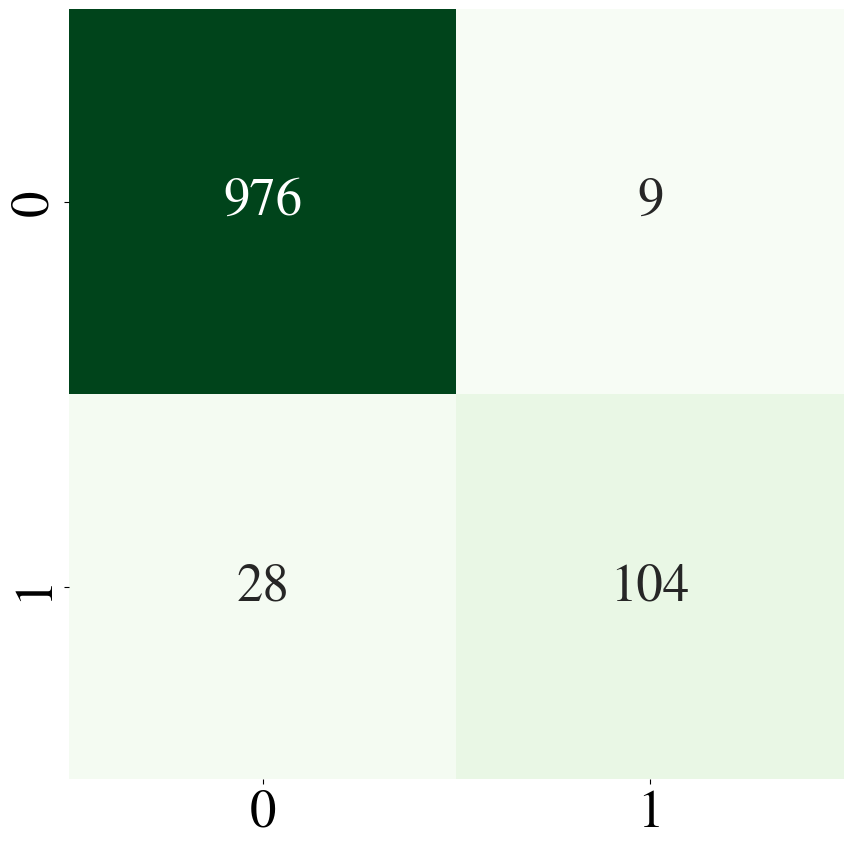

In [51]:
plot_confusion_matrix(y_test,y_pred,"Full features set")

In [25]:
model = grid_search.best_estimator_

In [26]:
df_X_train_full = pd.DataFrame(X_train,columns=df_transaction_weighted_opcode.columns[1:-1])
df_X_test_full = pd.DataFrame(X_test,columns=df_transaction_weighted_opcode.columns[1:-1])

df_X_train_full = df_X_train_full[best_features_set].copy()
df_X_test_full = df_X_test_full[best_features_set].copy()

model.fit(df_X_train_full,y_train.ravel())
y_pred_proba_best = model.predict_proba(df_X_test_full)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test,y_pred_proba_best)
auc_score = roc_auc_score(y_test,y_pred_proba_best)


y_pred_best = model.predict(df_X_test_full)
best_precision_test= precision_score(y_test, y_pred_best) # TP / (FP + TP)
best_recall_test = recall_score(y_test, y_pred_best)	     # TP / (FN + TP)
best_accuracy_test = accuracy_score(y_test, y_pred_best)	 # (TP + TN)/ (TP + FN + TN + FP)
best_f1_test = f1_score(y_test, y_pred_best)

print('AUC: {:.3f}'.format(auc_score))
print('Precision: {:.3f}'.format(best_precision_test))
print('Recall: {:.3f}'.format(best_recall_test))
print('Accuracy: {:.3f}'.format(best_accuracy_test))
print('F1: {:.3f}'.format(best_f1_test))

AUC: 0.978
Precision: 0.924
Recall: 0.826
Accuracy: 0.971
F1: 0.872


In [27]:
np.set_printoptions(threshold=sys.maxsize)

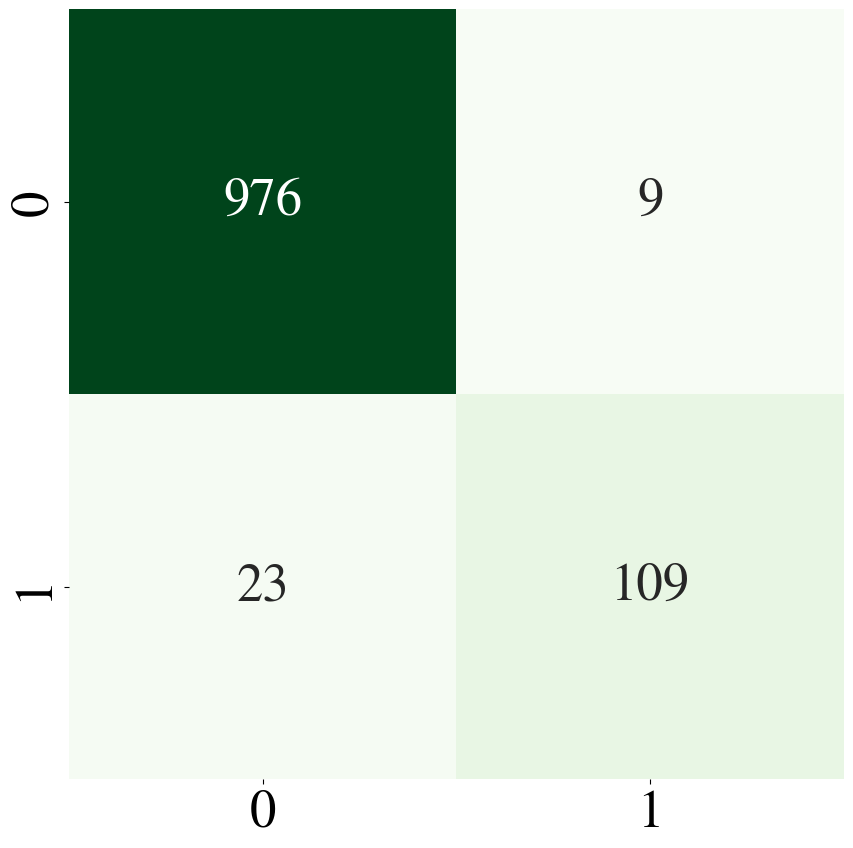

In [52]:
plot_confusion_matrix(y_test,y_pred_best,"Best features set")

In [30]:
cls = grid_search.best_estimator_

In [31]:
explainer_tree = shap.TreeExplainer(cls.named_steps['classifier'])
shap_values_tree = explainer_tree.shap_values(df_X_test_full)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [32]:
def get_shaps(classifier, dataset):
    print(dataset.shape)
    explainer = shap.Explainer(classifier, dataset)
    shap_values = explainer(dataset,check_additivity=False)

    explainer_tree = shap.TreeExplainer(classifier)
    shap_values_tree = explainer_tree.shap_values(dataset)
    return shap_values,shap_values_tree

In [40]:
def plot_beeswarn(df,shap_values,filename,class_index=1):
    shap.summary_plot(shap_values[class_index], df,show=False,max_display=12,color='red',color_bar=True,class_names=True)
    fig = plt.gcf() # gcf means "get current figure"
    ax = plt.gca() #gca means "get current axes"

    fig.axes[1].yaxis.get_label().set_fontsize(24)
    # fig.axes[1].set_fontsize(24)
    plt.xlabel('SHAP value',fontsize=20)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.tight_layout()
    plt.savefig('{}.png'.format(filename))

In [34]:
explainer = shap.Explainer(cls.named_steps['classifier'], df_X_test_full)
shap_values = explainer(df_X_test_full,check_additivity=False)

 99%|===================| 1110/1117 [00:12<00:00]        

In [35]:
shap_values, shap_values_tree = get_shaps(cls.named_steps['classifier'], df_X_test_full)

(1117, 43)


 99%|===================| 1106/1117 [00:19<00:00]        LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


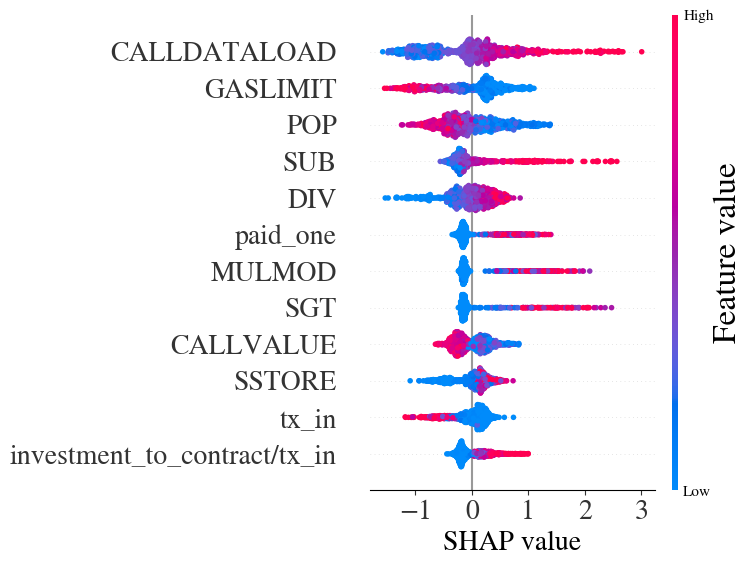

In [41]:
plot_beeswarn(df_X_test_full,shap_values_tree,'total',1)

In [42]:
from sklearn.inspection import PartialDependenceDisplay

In [43]:
top_twelve = [
 'CALLDATALOAD',
 'GASLIMIT',
 'POP',
 'SUB',
 'DIV',
 'paid_one',
 'MULMOD',
 'SGT',
 'CALLVALUE',
 'SSTORE',
 'tx_in',
 'investment_to_contract/tx_in'
]

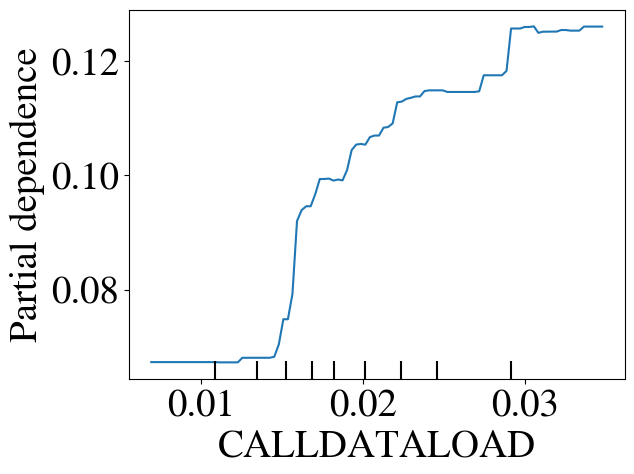

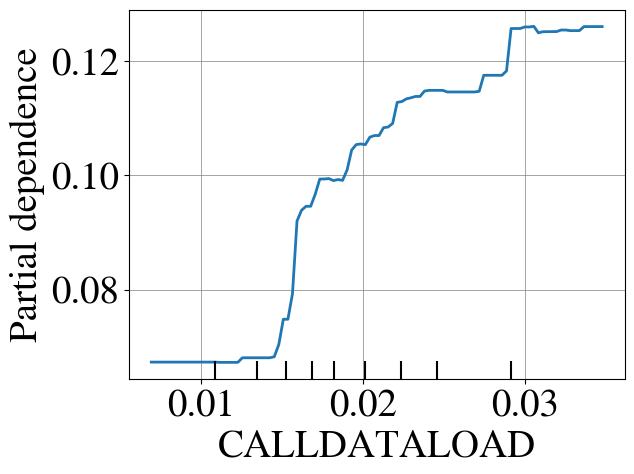

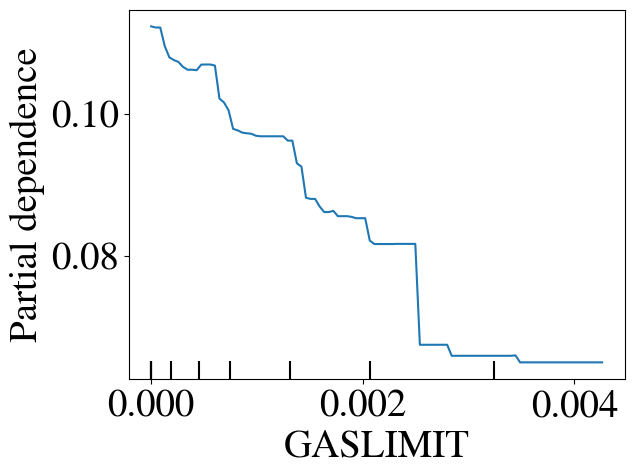

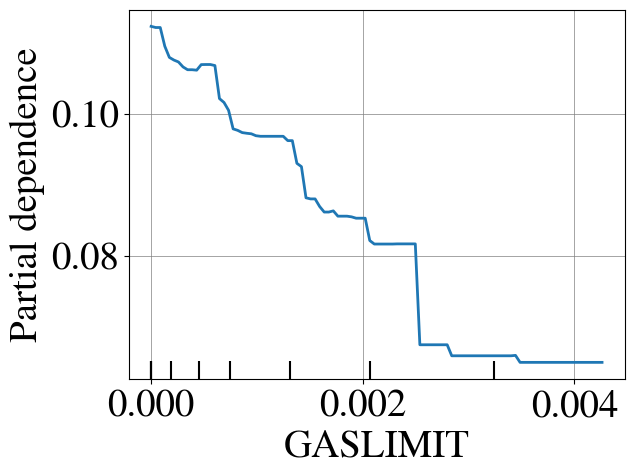

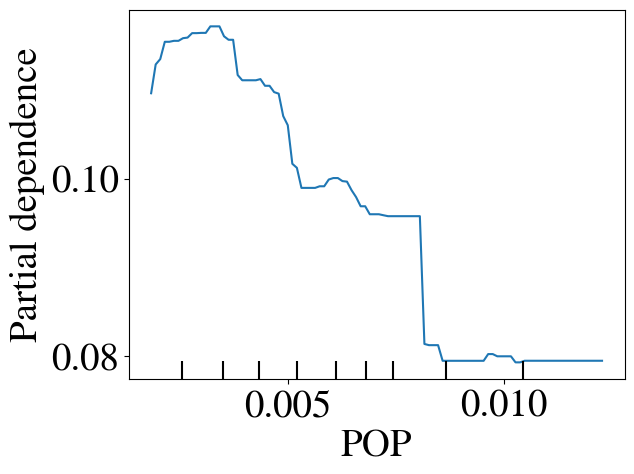

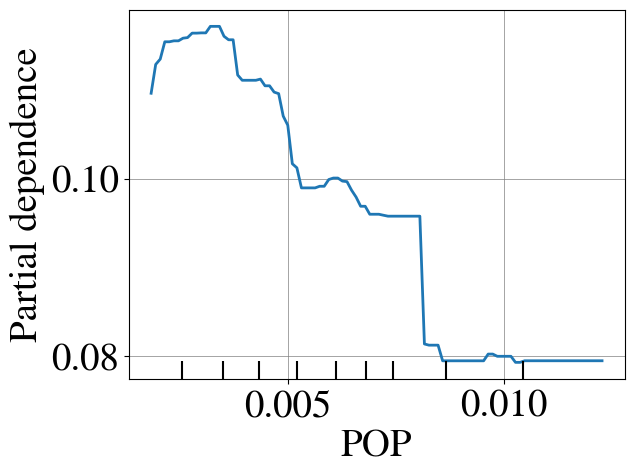

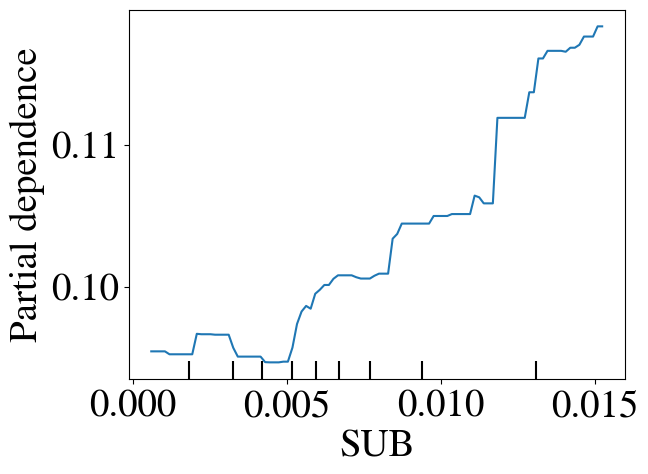

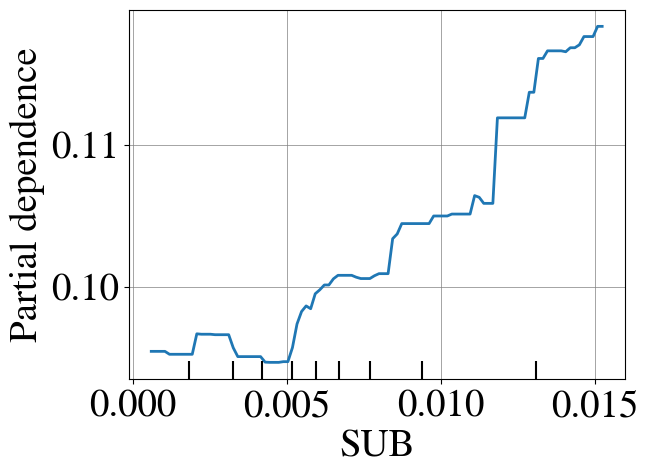

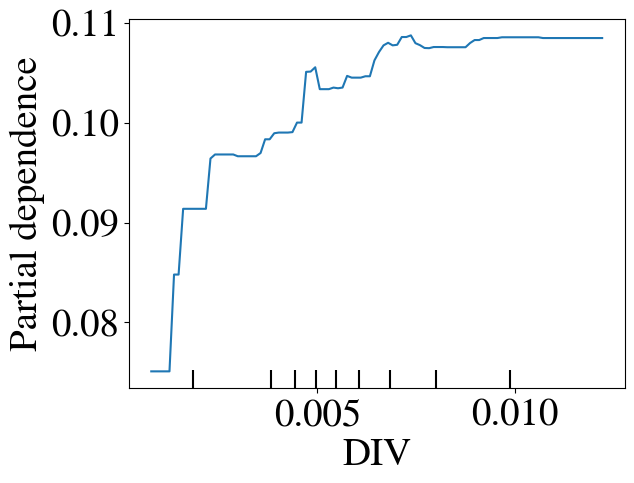

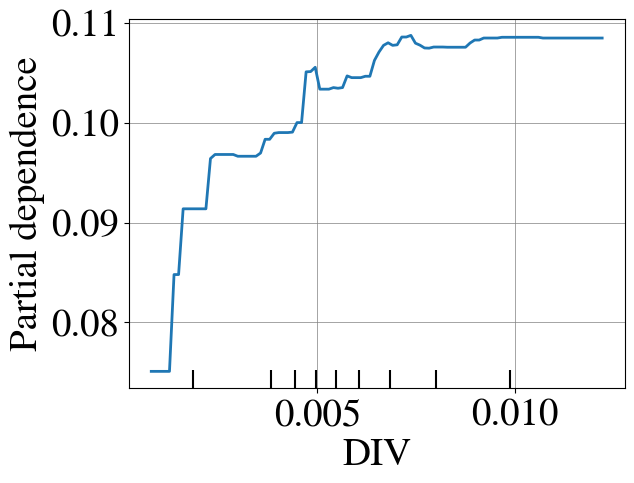

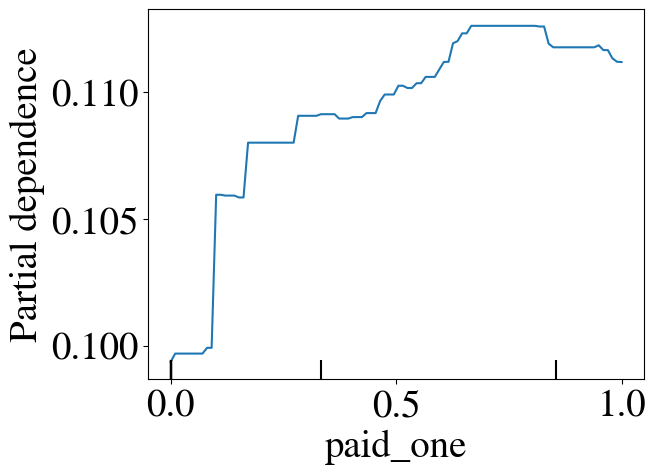

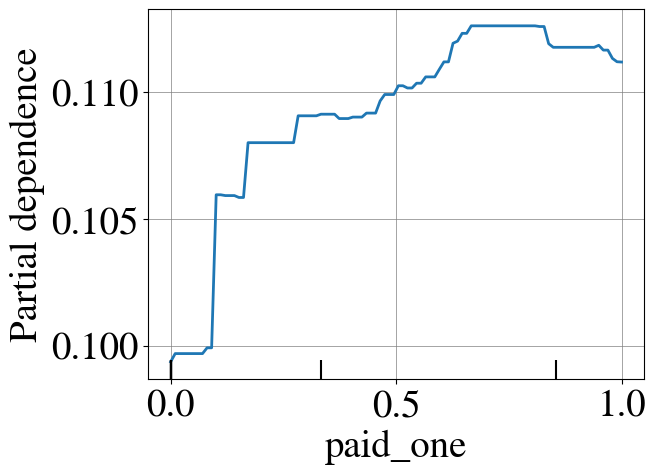

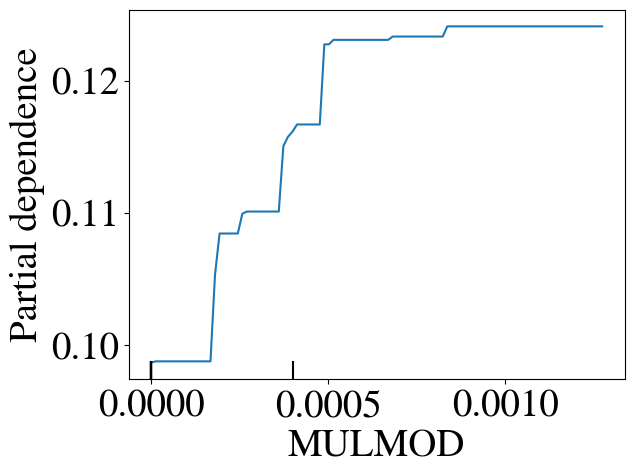

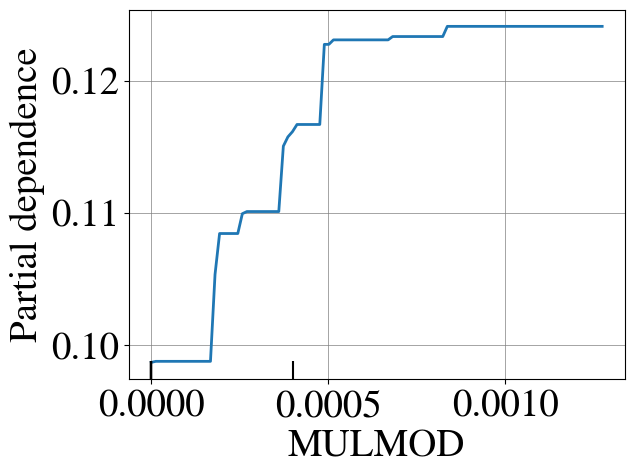

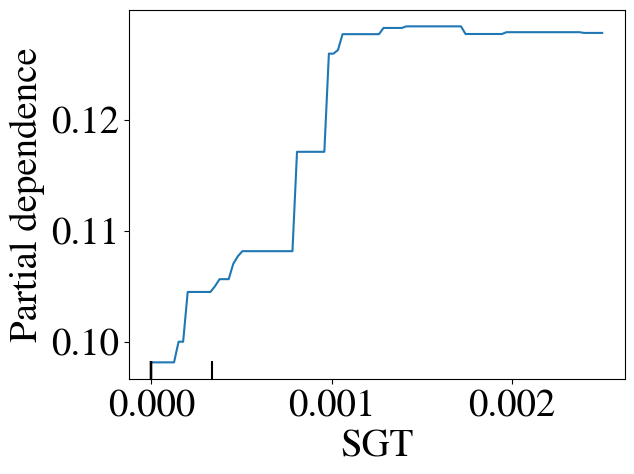

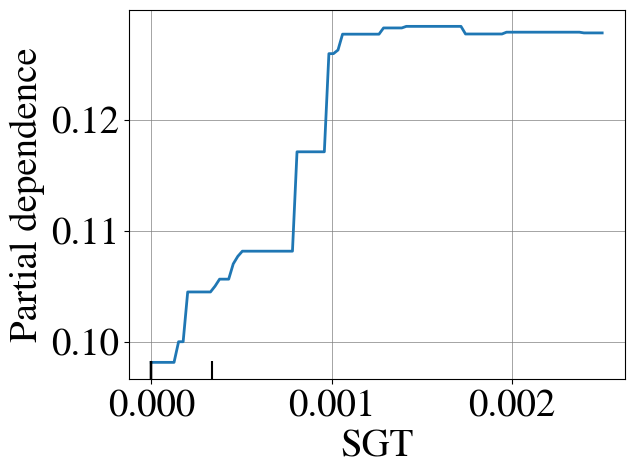

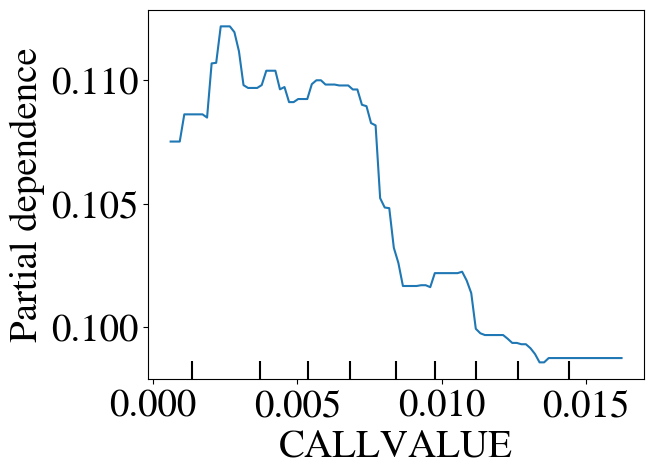

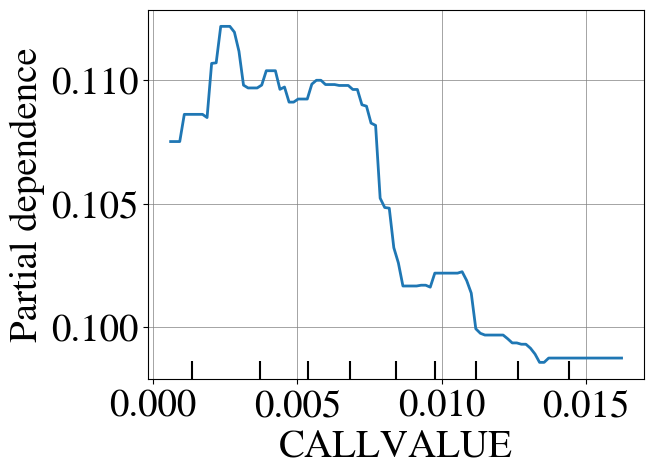

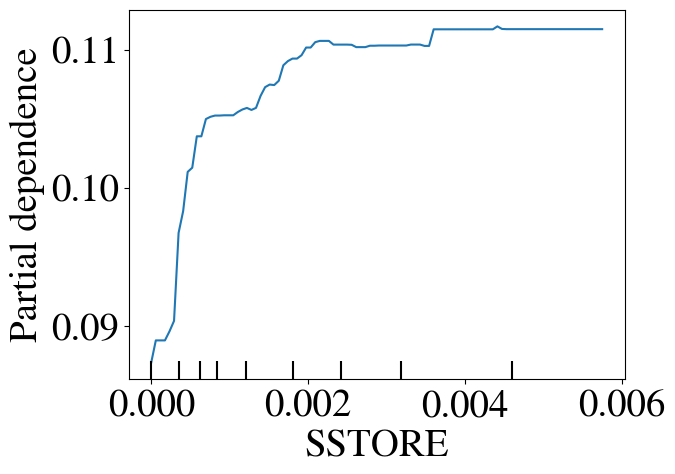

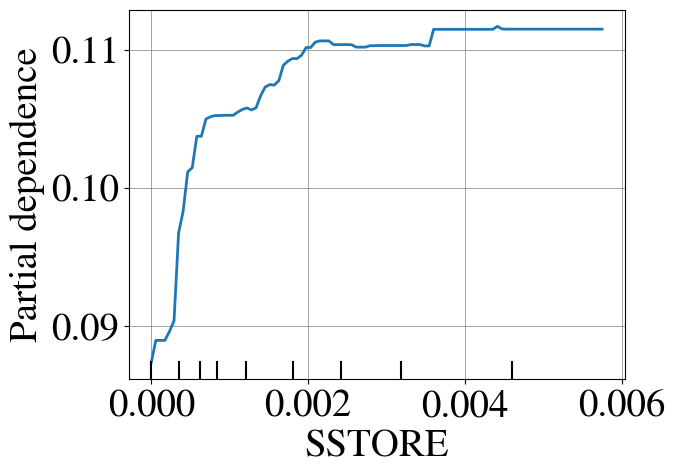

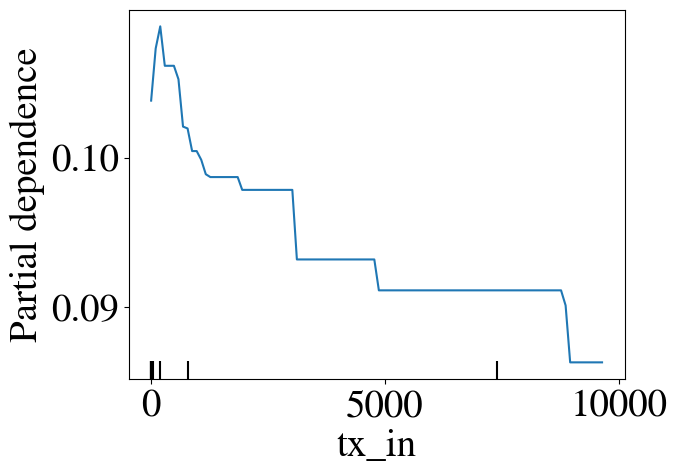

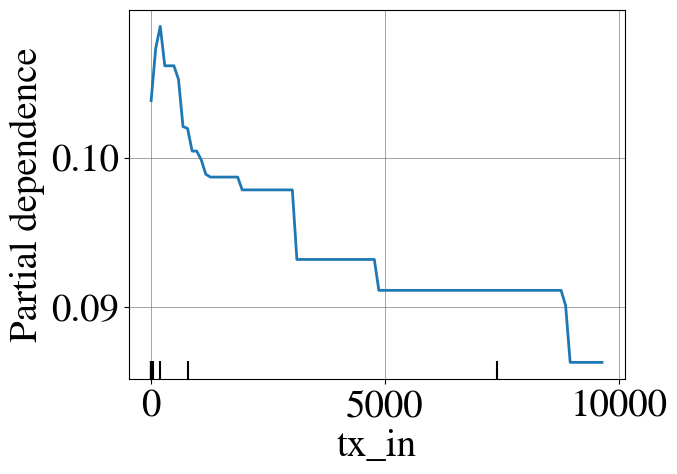

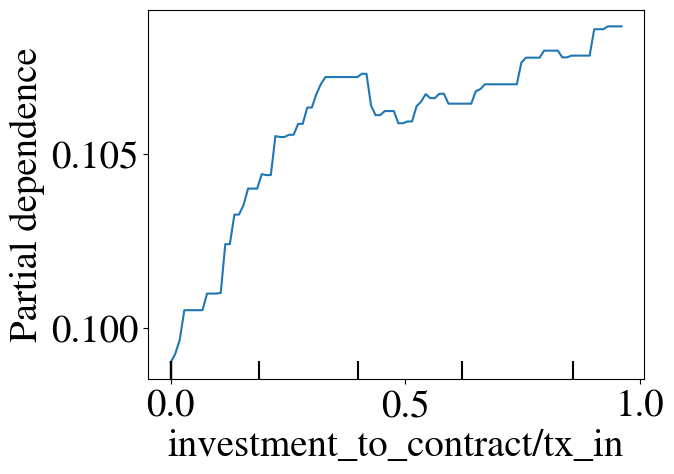

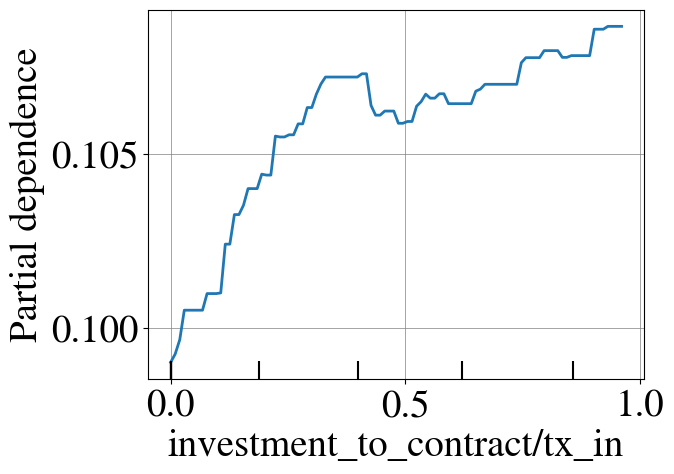

In [45]:
for x in top_twelve:
    pdp_display = PartialDependenceDisplay.from_estimator(cls, df_X_test_full, [x])
    plt.gca().set_facecolor('white')  # Set background color to white
    pdp_display.plot(line_kw={'linewidth': 2})
    plt.grid(color='gray', linestyle='-', linewidth=0.5)  # Add grid lines
    plt.gca().xaxis.grid(True)  # Show grid for x-axis
    plt.gca().yaxis.grid(True)  # Show grid for y-axis
    plt.show()

In [46]:
y_pred_proba_best = model.predict_proba(df_X_test_full)[:, 1]

In [47]:
model.predict_proba

<bound method Pipeline.predict_proba of Pipeline(steps=[('classifier',
                 LGBMClassifier(colsample_bytree=0.8, max_depth=20,
                                n_estimators=140, n_jobs=4, random_state=42,
                                reg_alpha=0, reg_lambda=1))])>

In [48]:
y_pred_proba_best

array([3.63941568e-04, 1.87299454e-04, 6.98672871e-04, 9.99258677e-01,
       4.96796389e-04, 3.31569444e-04, 2.14565976e-04, 3.39574142e-04,
       1.48632990e-04, 9.98480035e-01, 7.78593876e-04, 1.92765224e-04,
       2.12937017e-03, 8.22490523e-03, 1.40849297e-04, 4.29631090e-05,
       1.08178481e-02, 1.85413163e-01, 8.05769792e-04, 4.61006629e-02,
       9.99020901e-01, 3.08541304e-04, 1.19787511e-04, 9.91803415e-01,
       3.14237295e-04, 4.43516670e-05, 4.26314933e-04, 1.81083879e-04,
       1.20500337e-03, 7.55459412e-01, 4.82400949e-04, 9.99037249e-01,
       3.05378643e-04, 9.15094262e-04, 5.64447463e-04, 3.80478605e-03,
       6.66725124e-05, 5.45438523e-03, 2.52850918e-04, 5.70866356e-04,
       2.06853348e-04, 2.50927073e-03, 1.32459425e-02, 9.26842786e-04,
       3.20728295e-03, 5.68367312e-04, 1.12230206e-04, 6.75520853e-03,
       1.08878623e-04, 1.27565808e-02, 2.15321631e-03, 1.59083292e-04,
       4.15583037e-04, 9.75983619e-01, 1.34546111e-03, 7.87236867e-05,
      

False Negative and False Positive

In [53]:
df_check = df_X_test_full.copy()
df_check['prediction'] = y_pred
df_check['label'] = y_test
df_check['probability'] = y_pred_proba_best
df_check['correct'] = df_check.apply(lambda x: 1 if x.prediction == x.label else 0,axis=1)
df_check['address'] = df_X_test_adr

In [54]:
df_check

,tx_in,investment_to_contract/tx_in,mean_v1,sdev_v1,paid_one,PUSH,DUP,JUMPDEST,STOP,MSTORE,...,GAS,ORIGIN,BALANCE,MULMOD,SGT,prediction,label,probability,correct,address
5298,1.0,0.0000,0.00000,0.000000,0.0,0.236532,0.002309,0.039251,0.057978,0.158543,...,0.003592,0.000257,0.000000,0.000257,0.0,0.0,0.0,0.000364,1,0x8dc103a4864d4f6bab920e3fc9e3d48567bec173
679,101.0,0.0000,0.00000,0.000000,0.0,0.232034,0.000609,0.045676,0.061510,0.180877,...,0.010353,0.000609,0.000000,0.000000,0.0,0.0,0.0,0.000187,1,0x41ebb67c868f5f28bcd823ddbf39c0f32b191256
6269,8026.0,0.9993,0.26285,119.656997,0.0,0.242188,0.004261,0.022727,0.083807,0.134233,...,0.007102,0.000355,0.000000,0.000000,0.0,0.0,0.0,0.000699,1,0xbbc79794599b19274850492394004087cbf89710
2855,4.0,0.5000,0.00000,1.000000,1.0,0.241677,0.001233,0.022195,0.033292,0.171393,...,0.003699,0.001233,0.000000,0.000000,0.0,1.0,1.0,0.999259,1,0x0ec3cd77dbc5b512b5f9e45578813e1dbbcda719
6523,2.0,0.0000,0.00000,0.000000,0.0,0.299274,0.001373,0.028437,0.057462,0.136105,...,0.001569,0.000392,0.000000,0.000196,0.0,0.0,0.0,0.000497,1,0xc8e12d15592d7366cf8d9aa8fb0202faf5c00ab2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4191,1.0,0.0000,0.00000,0.000000,0.0,0.194371,0.000000,0.032542,0.024626,0.211082,...,0.002639,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000407,1,0x52070b253406fc4f2bf71dbaf910f66c45828dba
673,59.0,0.0000,0.00000,0.000000,0.0,0.295559,0.000131,0.031704,0.026333,0.138478,...,0.000524,0.001441,0.000000,0.000000,0.0,0.0,0.0,0.000261,1,0x41a1729dc30ba049adad9471d4da2401fa5b4889
6992,1.0,0.0000,0.00000,0.000000,0.0,0.278086,0.004699,0.027339,0.074327,0.125587,...,0.007689,0.000427,0.000000,0.000000,0.0,0.0,0.0,0.000131,1,0xe3dc86d70f09047da4131b599b9aaafdaf68b528
2910,1.0,0.0000,0.00000,0.000000,0.0,0.265096,0.001473,0.035346,0.049092,0.152185,...,0.002946,0.000491,0.000491,0.000000,0.0,0.0,0.0,0.001090,1,0x117820a67905555d4203d6915807d39921636b8d


prediction	label	probability

In [58]:
df_check.sort_values(by=['probability'])

,tx_in,investment_to_contract/tx_in,mean_v1,sdev_v1,paid_one,PUSH,DUP,JUMPDEST,STOP,MSTORE,...,GAS,ORIGIN,BALANCE,MULMOD,SGT,prediction,label,probability,correct,address
4511,7644.0,0.0000,0.000000,0.000000,0.0000,0.244940,0.001239,0.036762,0.039653,0.171004,...,0.005783,0.000413,0.000000,0.000000,0.000000,0.0,0.0,0.000026,1,0x626a14ec8bb0d92692ef704f19968c20727dede1
6723,9.0,0.0000,0.000000,0.000000,0.0000,0.244536,0.001649,0.036701,0.039588,0.171134,...,0.005773,0.000412,0.000000,0.000000,0.000000,0.0,0.0,0.000031,1,0xd451177ce7c4d7ebfe7109a239455d38aeb8c3d1
2000,3496.0,0.0000,0.000000,0.000000,0.0000,0.256170,0.001702,0.036170,0.065106,0.150213,...,0.005957,0.000426,0.000000,0.000000,0.000000,0.0,0.0,0.000033,1,0xc3951d77737733174152532e8b0f27e2c4e9f0dc
5552,90.0,0.0000,0.000000,0.000000,0.0000,0.244224,0.001238,0.037129,0.039604,0.170792,...,0.005776,0.000413,0.000000,0.000000,0.000000,0.0,0.0,0.000036,1,0x993890f752fd0f3d37c8bc5f3262c86b80d7c415
1871,9116.0,0.0000,0.000000,0.000000,0.0000,0.245707,0.002778,0.034091,0.058333,0.151263,...,0.005303,0.000505,0.000000,0.000000,0.000000,0.0,0.0,0.000037,1,0xb63b606ac810a52cca15e44bb630fd42d8d1d83d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5546,106.0,0.4434,-0.028571,0.999592,0.8857,0.266850,0.001376,0.020174,0.070151,0.145805,...,0.001376,0.000459,0.000000,0.000000,0.000000,1.0,1.0,0.999158,1,0x98fd6adfbf79b83f675e7214f70c98a1b7101b85
3659,2.0,0.5000,0.500000,0.500000,1.0000,0.219101,0.001404,0.025983,0.042837,0.182584,...,0.002107,0.000702,0.000702,0.002107,0.004213,1.0,1.0,0.999173,1,0x37b0d8b1299c1edf07a8ee4c5c1d245f17d56e3f
2855,4.0,0.5000,0.000000,1.000000,1.0000,0.241677,0.001233,0.022195,0.033292,0.171393,...,0.003699,0.001233,0.000000,0.000000,0.000000,1.0,1.0,0.999259,1,0x0ec3cd77dbc5b512b5f9e45578813e1dbbcda719
5025,23.0,0.8696,1.375000,6.725651,0.7143,0.236209,0.001414,0.018388,0.035361,0.171146,...,0.004243,0.001414,0.000000,0.000000,0.000000,1.0,1.0,0.999459,1,0x80d9c4f6209044de069c545f68644419b520a02f


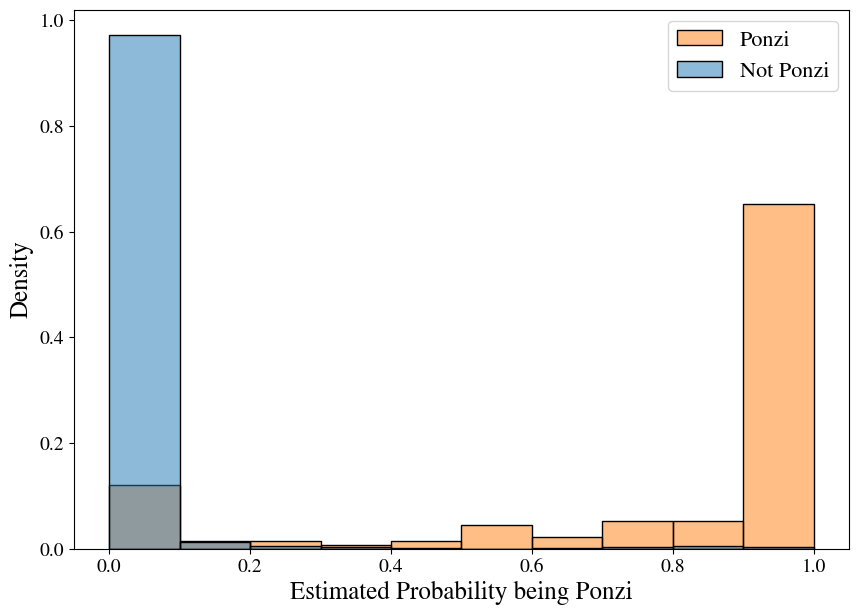

In [59]:
fig=plt.figure(figsize=(10,7))
sns.histplot(data=df_check,x='probability',hue='label',bins=np.arange(0,1.1,0.1),stat='probability',common_norm=False)
plt.xlabel('Estimated Probability being Ponzi',fontsize=18)
plt.ylabel('Density',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(loc='best',labels=['Ponzi','Not Ponzi'],fontsize=16)
plt.savefig('distribution_probability.png')

In [60]:
df_check['FP'] = df_check.apply(lambda x: 1 if x['prediction'] == 1 and x['correct'] ==0 else 0, axis=1 )
df_check['FN'] = df_check.apply(lambda x: 1 if x['prediction'] == 0 and x['correct'] ==0 else 0, axis=1 )

In [61]:
df_check

,tx_in,investment_to_contract/tx_in,mean_v1,sdev_v1,paid_one,PUSH,DUP,JUMPDEST,STOP,MSTORE,...,BALANCE,MULMOD,SGT,prediction,label,probability,correct,address,FP,FN
5298,1.0,0.0000,0.00000,0.000000,0.0,0.236532,0.002309,0.039251,0.057978,0.158543,...,0.000000,0.000257,0.0,0.0,0.0,0.000364,1,0x8dc103a4864d4f6bab920e3fc9e3d48567bec173,0,0
679,101.0,0.0000,0.00000,0.000000,0.0,0.232034,0.000609,0.045676,0.061510,0.180877,...,0.000000,0.000000,0.0,0.0,0.0,0.000187,1,0x41ebb67c868f5f28bcd823ddbf39c0f32b191256,0,0
6269,8026.0,0.9993,0.26285,119.656997,0.0,0.242188,0.004261,0.022727,0.083807,0.134233,...,0.000000,0.000000,0.0,0.0,0.0,0.000699,1,0xbbc79794599b19274850492394004087cbf89710,0,0
2855,4.0,0.5000,0.00000,1.000000,1.0,0.241677,0.001233,0.022195,0.033292,0.171393,...,0.000000,0.000000,0.0,1.0,1.0,0.999259,1,0x0ec3cd77dbc5b512b5f9e45578813e1dbbcda719,0,0
6523,2.0,0.0000,0.00000,0.000000,0.0,0.299274,0.001373,0.028437,0.057462,0.136105,...,0.000000,0.000196,0.0,0.0,0.0,0.000497,1,0xc8e12d15592d7366cf8d9aa8fb0202faf5c00ab2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4191,1.0,0.0000,0.00000,0.000000,0.0,0.194371,0.000000,0.032542,0.024626,0.211082,...,0.000000,0.000000,0.0,0.0,0.0,0.000407,1,0x52070b253406fc4f2bf71dbaf910f66c45828dba,0,0
673,59.0,0.0000,0.00000,0.000000,0.0,0.295559,0.000131,0.031704,0.026333,0.138478,...,0.000000,0.000000,0.0,0.0,0.0,0.000261,1,0x41a1729dc30ba049adad9471d4da2401fa5b4889,0,0
6992,1.0,0.0000,0.00000,0.000000,0.0,0.278086,0.004699,0.027339,0.074327,0.125587,...,0.000000,0.000000,0.0,0.0,0.0,0.000131,1,0xe3dc86d70f09047da4131b599b9aaafdaf68b528,0,0
2910,1.0,0.0000,0.00000,0.000000,0.0,0.265096,0.001473,0.035346,0.049092,0.152185,...,0.000491,0.000000,0.0,0.0,0.0,0.001090,1,0x117820a67905555d4203d6915807d39921636b8d,0,0


In [62]:
df_fp = df_check[df_check['FP']==1].copy()
df_fn = df_check[df_check['FN']==1].copy()

In [63]:
df_fp

,tx_in,investment_to_contract/tx_in,mean_v1,sdev_v1,paid_one,PUSH,DUP,JUMPDEST,STOP,MSTORE,...,BALANCE,MULMOD,SGT,prediction,label,probability,correct,address,FP,FN
6438,155.0,0.7484,-6.153846,4.221669,0.7692,0.234577,0.001523,0.020564,0.060929,0.162986,...,0.001523,0.001523,0.003046,1.0,0.0,0.288459,0,0xc3e777f1a1717be8d68300593d8bf83c33dd02f2,1,0
5401,4.0,0.5000,0.000000,1.000000,0.0000,0.267776,0.003530,0.022189,0.069592,0.136662,...,0.002017,0.000000,0.000000,1.0,0.0,0.981834,0,0x927a4e90c3728f04cc373cd4c445daafa9e54df7,1,0
3377,45.0,0.5556,-0.588235,1.032349,0.8125,0.256679,0.001431,0.029103,0.062977,0.158874,...,0.000477,0.000000,0.000000,1.0,0.0,0.786777,0,0x2992cfef496b9080b303cc4ac6ba114126253ff7,1,0
5370,48.0,0.2500,0.500000,3.041381,0.7500,0.273287,0.000300,0.062124,0.032752,0.160156,...,0.000075,0.000451,0.000901,1.0,0.0,0.962701,0,0x90f0a0f3880401aada42d6da27336cd6610368fe,1,0
2605,3.0,0.3333,-1.000000,0.000000,0.0000,0.262029,0.000746,0.028721,0.055203,0.150317,...,0.000186,0.000000,0.000000,1.0,0.0,0.352617,0,0x0064353c557afe927866f0f3b748bc271c385d71,1,0
985,719.0,0.6314,-20.727273,60.534124,0.7273,0.214592,0.000858,0.043777,0.032618,0.221459,...,0.000000,0.000000,0.000000,1.0,0.0,0.860741,0,0x5fe5b7546d1628f7348b023a0393de1fc825a4fd,1,0
6737,2.0,0.0000,0.000000,0.000000,0.0000,0.235710,0.004355,0.021230,0.043549,0.151334,...,0.000000,0.000544,0.001633,1.0,0.0,0.833100,0,0xd51a87caaa567677abac451b00e0a0a18a992b49,1,0
3751,168.0,0.0417,-1.000000,0.000000,0.0000,0.251869,0.001416,0.030293,0.040916,0.165080,...,0.000079,0.002361,0.006059,1.0,0.0,0.885215,0,0x3cfa6d2e89704bd7ff443004c7dbfc8ab0c1f5d7,1,0
4532,91.0,0.9780,0.000000,6.593223,0.9333,0.217476,0.011650,0.007767,0.064078,0.157282,...,0.000000,0.001942,0.003883,1.0,0.0,0.121425,0,0x63a74a8abf527ab9e564c3521d685bed11bd699c,1,0


In [64]:
df_fp["address"]

6438    0xc3e777f1a1717be8d68300593d8bf83c33dd02f2
5401    0x927a4e90c3728f04cc373cd4c445daafa9e54df7
3377    0x2992cfef496b9080b303cc4ac6ba114126253ff7
5370    0x90f0a0f3880401aada42d6da27336cd6610368fe
2605    0x0064353c557afe927866f0f3b748bc271c385d71
985     0x5fe5b7546d1628f7348b023a0393de1fc825a4fd
6737    0xd51a87caaa567677abac451b00e0a0a18a992b49
3751    0x3cfa6d2e89704bd7ff443004c7dbfc8ab0c1f5d7
4532    0x63a74a8abf527ab9e564c3521d685bed11bd699c
Name: address, dtype: object

In [65]:
df_fn["address"]

7235    0xf1aa63ad7a897ca02cab6021513ee0a86820153e
7170    0xedcb4363c812ffbdc45777f1029bdcc549fe5fac
3775    0x3dddcf24a8cfbc603a213e772ef07f4f44270ba5
3184    0x1fe7a92013b295ff98da0954b7a08e603754a1bf
4675    0x6ca7f214ab2ddbb9a8e1a1e2c8550e3164e9dba5
4352    0x5a8ffa5f2ce95b3a397bda16ad84781b6fde4f8b
3911    0x446a2c358315ca32d7c5b3ac696b82271141a8b1
3739    0x3c34071180ceb4213da92d065f87adcb835028c4
7416    0xfc4f1acaaed191715cd50b9bc5311f7ad076424e
5416    0x934e65cead3c1c2824ed75d54768d53fa44e4e17
3524    0x309a0465ba40b6b756ef4899dd624ead009a8f50
5520    0x979bc5ecc41b701efabd550b98cedbc137cbb0af
2702    0x05e2d7e3af7df59232d20e916751b9f5b66093b7
3291    0x24f9c2c5032d22153e97205b93339f3496a3a3b5
6297    0xbdb8b73aea0c43118ce8834c91d50ae8bbd5ed32
6610    0xce9ed0b322a1420da4b6990e3047796f57471336
7046    0xe65c53087e1a40b7c53b9a0ea3c2562ae2dfeb24
468     0x2df0e612dad9ffe8141b3987f60608742db2feca
6240    0xba6284ca128d72b25f1353fadd06aa145d9095af
3166    0x1e997b4a256e11071167a

In [66]:
df_fn.sort_index()

,tx_in,investment_to_contract/tx_in,mean_v1,sdev_v1,paid_one,PUSH,DUP,JUMPDEST,STOP,MSTORE,...,BALANCE,MULMOD,SGT,prediction,label,probability,correct,address,FP,FN
468,34.0,0.9412,-1.380952,1.132893,0.0500,0.268574,0.002415,0.033432,0.054421,0.138187,...,0.000000,0.000000,0.000000,0.0,1.0,0.027906,0,0x2df0e612dad9ffe8141b3987f60608742db2feca,0,1
2702,6.0,0.6667,2.750000,3.112475,1.0000,0.231821,0.003600,0.020158,0.043197,0.179266,...,0.000000,0.000000,0.000000,0.0,1.0,0.039820,0,0x05e2d7e3af7df59232d20e916751b9f5b66093b7,0,1
2710,27.0,0.6667,0.222222,2.249829,0.8571,0.257386,0.000809,0.025900,0.046945,0.150951,...,0.000000,0.000405,0.000000,0.0,1.0,0.567288,0,0x06300cec31cf8edf74a17dac79cbc66355113179,0,1
3166,2.0,0.5000,-1.000000,0.000000,0.0000,0.259335,0.002741,0.022953,0.059952,0.137718,...,0.000000,0.000000,0.000000,0.0,1.0,0.113356,0,0x1e997b4a256e11071167a1d08e98a9f5dde0bf72,0,1
3184,140.0,0.5929,-0.619718,0.909515,0.4857,0.229819,0.003295,0.032537,0.069193,0.148682,...,0.000412,0.000000,0.000000,0.0,1.0,0.086280,0,0x1fe7a92013b295ff98da0954b7a08e603754a1bf,0,1
3237,8.0,0.3750,0.333333,0.471405,1.0000,0.234098,0.003279,0.030164,0.068852,0.177049,...,0.002623,0.000000,0.000000,0.0,1.0,0.002015,0,0x2244af1453e6c4a0c9165f8e5fbdded131ad35d6,0,1
3291,20.0,0.9000,-2.333333,2.687419,0.6000,0.210619,0.002347,0.029627,0.046935,0.190965,...,0.000587,0.000000,0.000000,0.0,1.0,0.437260,0,0x24f9c2c5032d22153e97205b93339f3496a3a3b5,0,1
3336,1048.0,0.0019,0.000000,0.000000,1.0000,0.185107,0.003366,0.029870,0.038704,0.216239,...,0.000000,0.000841,0.001683,0.0,1.0,0.409999,0,0x27705979b6f4d3b497f62240a6ae11ae535a49df,0,1
3362,217.0,0.5991,-0.282051,1.357764,0.8077,0.241692,0.001511,0.042296,0.050604,0.177492,...,0.000000,0.000000,0.000000,0.0,1.0,0.001698,0,0x28cf9af3aca6aea0b802df31629ce1b7aa243dc2,0,1
3524,3.0,0.6667,0.000000,2.000000,0.0000,0.258919,0.003058,0.031600,0.045872,0.144750,...,0.001019,0.000000,0.000000,0.0,1.0,0.389421,0,0x309a0465ba40b6b756ef4899dd624ead009a8f50,0,1


In [67]:
df_fp

,tx_in,investment_to_contract/tx_in,mean_v1,sdev_v1,paid_one,PUSH,DUP,JUMPDEST,STOP,MSTORE,...,BALANCE,MULMOD,SGT,prediction,label,probability,correct,address,FP,FN
6438,155.0,0.7484,-6.153846,4.221669,0.7692,0.234577,0.001523,0.020564,0.060929,0.162986,...,0.001523,0.001523,0.003046,1.0,0.0,0.288459,0,0xc3e777f1a1717be8d68300593d8bf83c33dd02f2,1,0
5401,4.0,0.5000,0.000000,1.000000,0.0000,0.267776,0.003530,0.022189,0.069592,0.136662,...,0.002017,0.000000,0.000000,1.0,0.0,0.981834,0,0x927a4e90c3728f04cc373cd4c445daafa9e54df7,1,0
3377,45.0,0.5556,-0.588235,1.032349,0.8125,0.256679,0.001431,0.029103,0.062977,0.158874,...,0.000477,0.000000,0.000000,1.0,0.0,0.786777,0,0x2992cfef496b9080b303cc4ac6ba114126253ff7,1,0
5370,48.0,0.2500,0.500000,3.041381,0.7500,0.273287,0.000300,0.062124,0.032752,0.160156,...,0.000075,0.000451,0.000901,1.0,0.0,0.962701,0,0x90f0a0f3880401aada42d6da27336cd6610368fe,1,0
2605,3.0,0.3333,-1.000000,0.000000,0.0000,0.262029,0.000746,0.028721,0.055203,0.150317,...,0.000186,0.000000,0.000000,1.0,0.0,0.352617,0,0x0064353c557afe927866f0f3b748bc271c385d71,1,0
985,719.0,0.6314,-20.727273,60.534124,0.7273,0.214592,0.000858,0.043777,0.032618,0.221459,...,0.000000,0.000000,0.000000,1.0,0.0,0.860741,0,0x5fe5b7546d1628f7348b023a0393de1fc825a4fd,1,0
6737,2.0,0.0000,0.000000,0.000000,0.0000,0.235710,0.004355,0.021230,0.043549,0.151334,...,0.000000,0.000544,0.001633,1.0,0.0,0.833100,0,0xd51a87caaa567677abac451b00e0a0a18a992b49,1,0
3751,168.0,0.0417,-1.000000,0.000000,0.0000,0.251869,0.001416,0.030293,0.040916,0.165080,...,0.000079,0.002361,0.006059,1.0,0.0,0.885215,0,0x3cfa6d2e89704bd7ff443004c7dbfc8ab0c1f5d7,1,0
4532,91.0,0.9780,0.000000,6.593223,0.9333,0.217476,0.011650,0.007767,0.064078,0.157282,...,0.000000,0.001942,0.003883,1.0,0.0,0.121425,0,0x63a74a8abf527ab9e564c3521d685bed11bd699c,1,0


In [68]:
df_shap_fn = df_fn.sort_values('probability',ascending=False)[df_X_test_full.columns].copy()

In [69]:
shap_fn, shap_fn_tree = get_shaps(cls.named_steps['classifier'],df_shap_fn)

(28, 43)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


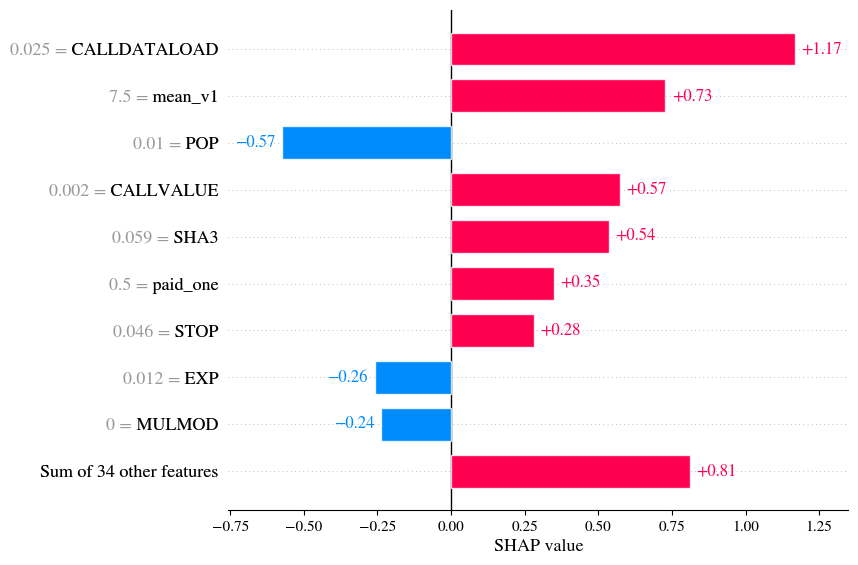

In [72]:
shap.plots.bar(shap_fn[1],show_data=True)


In [73]:
df_shap_fp = df_fp.sort_values('probability',ascending=False)[df_X_test_full.columns].copy()
shap_fp, shap_fp_tree = get_shaps(cls.named_steps['classifier'],df_shap_fp)

(9, 43)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


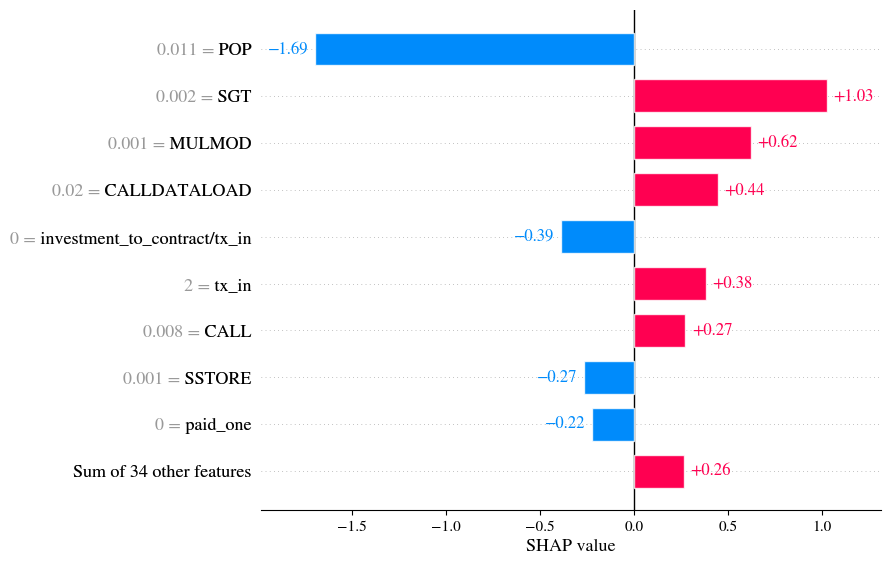

In [78]:
shap.plots.bar(shap_fp[4],show_data=True)

In [79]:
shap.initjs()
shap.force_plot(shap_fp[1])


In [80]:

shap.force_plot(shap_fp[1])

PDP with SHAP

In [83]:
top_twelve

['CALLDATALOAD',
 'GASLIMIT',
 'POP',
 'SUB',
 'DIV',
 'paid_one',
 'MULMOD',
 'SGT',
 'CALLVALUE',
 'SSTORE',
 'tx_in',
 'investment_to_contract/tx_in']

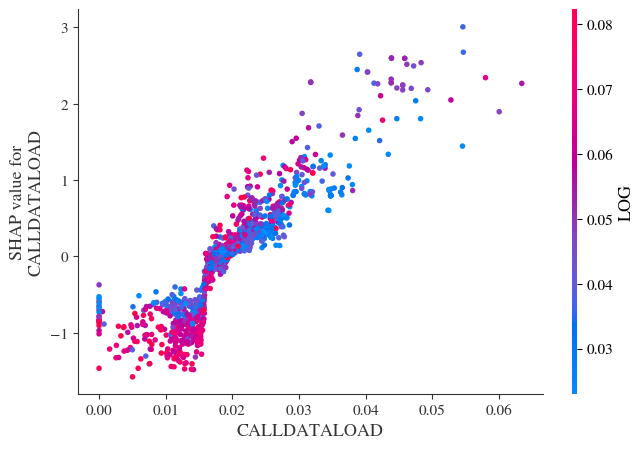

In [84]:
shap.dependence_plot("CALLDATALOAD", shap_values_tree[1], df_X_test_full)

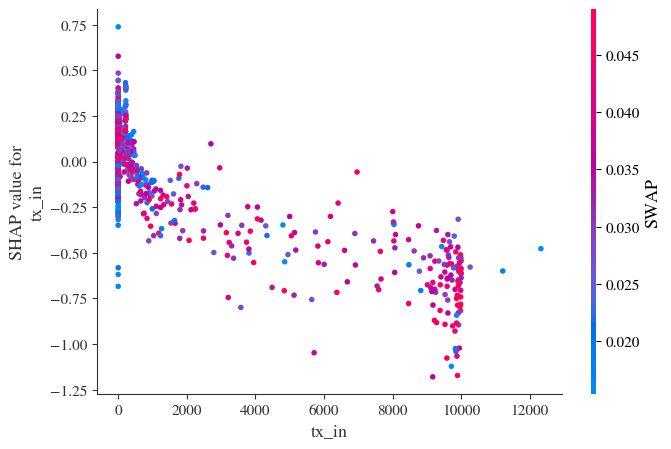

In [85]:
shap.dependence_plot("tx_in", shap_values_tree[1], df_X_test_full)

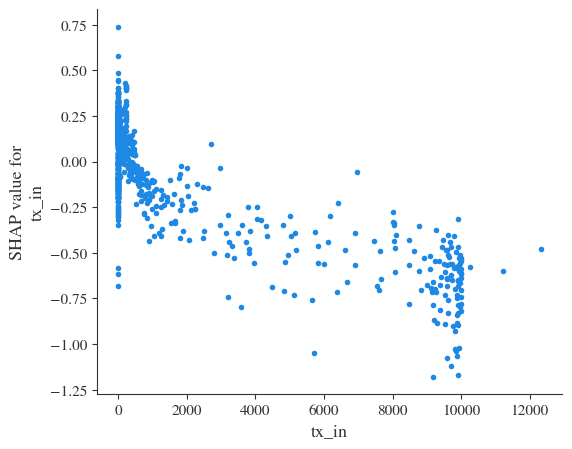

In [86]:
shap.dependence_plot("tx_in", shap_values_tree[1], df_X_test_full,  interaction_index=None)